In [8]:
import csv
import os.path
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from rbflayer import RBFLayer, InitCentersRandom
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import datasets, linear_model

import matplotlib.pyplot as plt
import math
import pandas as pd

This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years.
The goal is to predict the number of shares in social networks (popularity).<br>
<br>
Reference material <br>
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/3155681567642906/2202577924924539/latest.html<br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/ <br>
https://github.com/PetraVidnerova/rbf_keras/blob/master/rbflayer.py <br>
https://archive.ics.uci.edu/ml/datasets/online+news+popularity <br><br>
Target is element 60, shares:     Number of shares
<br>
Omitted url, timedelta, LDA, is_weekend, kw_min_min, kw_avg_min, kw_min_avg<br>
Convert following binary data to categorical data, weekday, data_channel

In [9]:
# loading of dataset 
dataset = []
labels = []
headers = []

def load_dataset_raw():
    global dataset, labels, headers
    with open('OnlineNewsPopularity.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        headers = next(reader) # the first row
        headers = headers[1:]
        headers = [x.strip(' ') for x in headers]    
            
        temp_data = []
        temp_label = []
        for idx, row in enumerate(reader):
            temp_data.append(row[1:])
            temp_label.append(row[-1])

        # convert elements to float        
        for idx, row in enumerate(temp_data):        
            dataset.append([float(i) for i in row[:]])
        for idx, row in enumerate(temp_label):
            labels.append(float(row))   
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def load_dataset(is_normalize=True, is_remove_outlier=True, select_top=50):
    """
    is_normalize: To normalize or keep orignal form
    is_remove_outlier: To remove outlier 
    select_top: select top important features using PCA (Principal component analysis)
    """
    global dataset, labels, headers
    dataset, labels = load_dataset_raw()
    print('Original dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))
    
    fields_to_avoid = [0, 18, 20, 24, 38, 39, 40, 41, 42]
    weekday = [30, 31, 32, 33, 34, 35, 36, 37]
    data_channel = [12, 13, 14, 15, 16, 17]
    fields_to_avoid = fields_to_avoid + weekday + data_channel
    fields_to_avoid = sorted(fields_to_avoid)

    # adjust headers
    sub_headers = []
    for idx, h in enumerate(headers):
        if idx not in fields_to_avoid:
            sub_headers.append(h)
    sub_headers.insert(len(sub_headers) - 1, 'weekday')
    sub_headers.insert(len(sub_headers) - 1, 'data_channel')
    headers = sub_headers
    
    # filter columns and categorical fields
    new_dataset = []        
    for idx, row in enumerate(dataset):
        slice_row = [i for num,i in enumerate(row) if num not in fields_to_avoid]
        insert_idx = len(slice_row) - 1

        for col_idx in range(len(row)):
            # convert week day to categorical 
            if col_idx in weekday and row[col_idx] == 1:
                if col_idx == 30:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 31:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 32:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 33:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 34:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 35:
                    slice_row.insert(insert_idx, 6)
                elif col_idx == 36:
                    slice_row.insert(insert_idx, 7)

            # convert data channel to categorical 
            if col_idx in data_channel and row[col_idx] == 1:
                if col_idx == 12:
                    slice_row.insert(insert_idx, 1)
                elif col_idx == 13:
                    slice_row.insert(insert_idx, 2)
                elif col_idx == 14:
                    slice_row.insert(insert_idx, 3)
                elif col_idx == 15:
                    slice_row.insert(insert_idx, 4)
                elif col_idx == 16:
                    slice_row.insert(insert_idx, 5)
                elif col_idx == 17:
                    slice_row.insert(insert_idx, 6)

        # handle missing data
        if len(slice_row) == 38:
            slice_row.append(0)
        new_dataset.append(slice_row)         
    
    # copy filter new_dataset to dataset 
    dataset = new_dataset
    
    # normalizing in dataset
    if is_normalize:
        # it is important which type of normalization method you use
        scaler = preprocessing.MinMaxScaler()
        dataset = scaler.fit_transform(dataset)
        # last item uses MinMaxScaler
        labels = np.array(labels).reshape(-1, 1)
        scaler = preprocessing.QuantileTransformer()
        labels = scaler.fit_transform(labels)
        print('Data is normalize')
    else:
        print('No normalize apply')        

    # remove outlier in dataset
    if is_remove_outlier:
        dataset, labels = reject_outliers(dataset, labels)    

    # applying PCA in dataset
    if 0 < select_top < len(dataset[0]):
        top_features = pca_important_features(dataset, headers, top=select_top)
        feature_keys = [f[1] for f in top_features]
        df = pd.DataFrame(dataset, columns=headers)
        top_dataset = []
        for name in feature_keys:
            top_dataset.append(df.loc[:, name])
        dataset = np.transpose(top_dataset)
        
    return np.array(dataset), np.array(labels).reshape(-1, 1)

def pca_important_features(dataset, headers, top=10):
    scaleFeatures = True
    pca = PCA(n_components=top)
    projected  = pca.fit_transform(dataset)
    top_features = extract_features(projected, pca.components_, headers, top)
    return top_features
    
def extract_features(transformed_features, components_, columns, top):
    num_columns = len(columns)

    # This funtion will project your *original* feature (columns)
    # onto your principal component feature-space, so that you can
    # visualize how "important" each one was in the
    # multi-dimensional scaling

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print("Features by top {0} importance:".format(top))
    for feature in important_features[:top]:
        print(feature)
    print()
    return important_features[:top]
        
def reject_outliers(dataset, labels, m=50):        
    """
    Higher the value 'm' more outliers
    """
    d = np.abs(labels - np.median(labels))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
        
    # remove outliers in dataset and labels
    sub_dataset = []
    sub_labels = []
    outlier_labels = []
    for idx, item in enumerate(s):        
        if item < m:
            sub_labels.append(labels[idx])
            sub_dataset.append(dataset[idx])        
        else:
            outlier_labels.append(labels[idx])
    print('Outlier removed: {0}'.format(len(outlier_labels)))
    return sub_dataset, sub_labels

In [10]:
# Splitting of dataset into train and test
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True, is_remove_outlier=True, select_top=-1)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, shuffle=False, random_state=42)
print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))

# print(dataset[0])
# print(labels[:-10])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
x_train: (31715, 39), y_train: (31715, 1)
x_test: (7929, 39), y_test: (7929, 1)


dataset (39644, 39)
labels (39644, 1)
Labels max value: 0.9999999000000003
Labels min value: 9.999999977795539e-08
Labels avg value: 0.5000743959674698


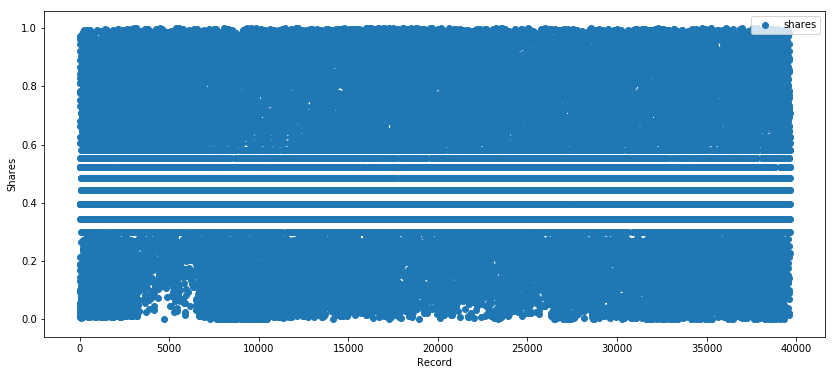

In [11]:
# Quick view of processed datasets
print('dataset {0}'.format(dataset.shape))
print('labels {0}'.format(labels.shape))
print('Labels max value: {0}'.format(np.max(labels)))
print('Labels min value: {0}'.format(np.min(labels)))
print('Labels avg value: {0}'.format(np.average(labels)))

def show_graph(data):
    plt.figure(figsize=(14,6))
    plt.xlabel("Record")
    plt.ylabel("Shares")
    plt.title("")
    x = list(range(len(data)))
    plt.scatter(x, [pt[0] for pt in data], label='shares')
    plt.legend(loc='upper right')
    plt.show()

def show_histogram(data):
    plt.figure(figsize=(14,6))
    plt.hist(data, 100)
    plt.show()

show_graph(labels)
# show_histogram(labels)

**Reference**<br>
*kernel_regularizer*: Regularizer function applied to the kernel weights matrix (see regularizer).<br>
*activity_regularizer*: Regularizer function applied to the output of the layer (its "activation").

In [12]:
# build model
l2_kernal = 0.0001

model = Sequential()
model.add(Dense(512, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               20480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
__________

In [13]:
# training with callbacks
saved_weights_name = 'best_weights_mlp.h5'

if os.path.isfile(saved_weights_name):
    model.load_weights(saved_weights_name)
    print("Weights loaded: {0}".format(saved_weights_name))

early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001,
                           patience=10,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint(saved_weights_name,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              min_lr=0.00001,
                              verbose=1)
    
history = model.fit(x_train, y_train,
                      epochs=80,
                      validation_data=(x_test, y_test),
                      callbacks=[early_stop, checkpoint, reduce_lr],
                      verbose=1)

Train on 31715 samples, validate on 7929 samples
Epoch 1/80
31715/31715 [==============================] - 4s 117us/step - loss: 0.0987 - mean_squared_error: 0.0831 - val_loss: 0.0806 - val_mean_squared_error: 0.0780

Epoch 00001: val_loss improved from inf to 0.08065, saving model to best_weights_mlp.h5
Epoch 2/80
31715/31715 [==============================] - 4s 111us/step - loss: 0.0834 - mean_squared_error: 0.0808 - val_loss: 0.0769 - val_mean_squared_error: 0.0745

Epoch 00002: val_loss improved from 0.08065 to 0.07694, saving model to best_weights_mlp.h5
Epoch 3/80
31715/31715 [==============================] - 4s 113us/step - loss: 0.0826 - mean_squared_error: 0.0801 - val_loss: 0.0756 - val_mean_squared_error: 0.0731

Epoch 00003: val_loss improved from 0.07694 to 0.07560, saving model to best_weights_mlp.h5
Epoch 4/80
31715/31715 [==============================] - 3s 106us/step - loss: 0.0814 - mean_squared_error: 0.0786 - val_loss: 0.0754 - val_mean_squared_error: 0.0726

Epo

31715/31715 [==============================] - 3s 103us/step - loss: 0.0346 - mean_squared_error: 0.0231 - val_loss: 0.0243 - val_mean_squared_error: 0.0129

Epoch 00035: val_loss improved from 0.02435 to 0.02429, saving model to best_weights_mlp.h5
Epoch 36/80
31715/31715 [==============================] - 3s 104us/step - loss: 0.0346 - mean_squared_error: 0.0230 - val_loss: 0.0245 - val_mean_squared_error: 0.0130

Epoch 00036: val_loss did not improve
Epoch 37/80
31715/31715 [==============================] - 3s 103us/step - loss: 0.0339 - mean_squared_error: 0.0224 - val_loss: 0.0241 - val_mean_squared_error: 0.0127

Epoch 00037: val_loss improved from 0.02429 to 0.02408, saving model to best_weights_mlp.h5
Epoch 38/80
31715/31715 [==============================] - 3s 106us/step - loss: 0.0344 - mean_squared_error: 0.0229 - val_loss: 0.0241 - val_mean_squared_error: 0.0127

Epoch 00038: val_loss improved from 0.02408 to 0.02407, saving model to best_weights_mlp.h5
Epoch 39/80
31715/


Epoch 00069: val_loss improved from 0.02280 to 0.02273, saving model to best_weights_mlp.h5
Epoch 70/80
31715/31715 [==============================] - 4s 114us/step - loss: 0.0333 - mean_squared_error: 0.0220 - val_loss: 0.0226 - val_mean_squared_error: 0.0113

Epoch 00070: val_loss improved from 0.02273 to 0.02256, saving model to best_weights_mlp.h5
Epoch 71/80
31715/31715 [==============================] - 3s 106us/step - loss: 0.0331 - mean_squared_error: 0.0218 - val_loss: 0.0230 - val_mean_squared_error: 0.0117

Epoch 00071: val_loss did not improve
Epoch 72/80
31715/31715 [==============================] - 3s 106us/step - loss: 0.0326 - mean_squared_error: 0.0213 - val_loss: 0.0228 - val_mean_squared_error: 0.0116

Epoch 00072: val_loss did not improve
Epoch 73/80
31715/31715 [==============================] - 4s 111us/step - loss: 0.0326 - mean_squared_error: 0.0213 - val_loss: 0.0226 - val_mean_squared_error: 0.0114

Epoch 00073: val_loss did not improve
Epoch 74/80
31715/317

*** Recall our target is last element Shares *** <br>
Shares: Number of shares

7929/7929 [==============================] - 0s 33us/step
actual max 0.9992343966165429
actual min 6.387735547748322e-05
actual median 0.4444444444444444
predict max 1.0
predict min 0.2504976689815521
predict median 0.4072563350200653

loss: 0.022189
mean_squared_error: 0.01104
root_mse: 0.105073
explained_variance_score: 0.817475
mean_absolute_error: 0.07962
mean_squared_log_error: 0.006801
median_absolute_error: 0.056895
r2_score: 0.810248


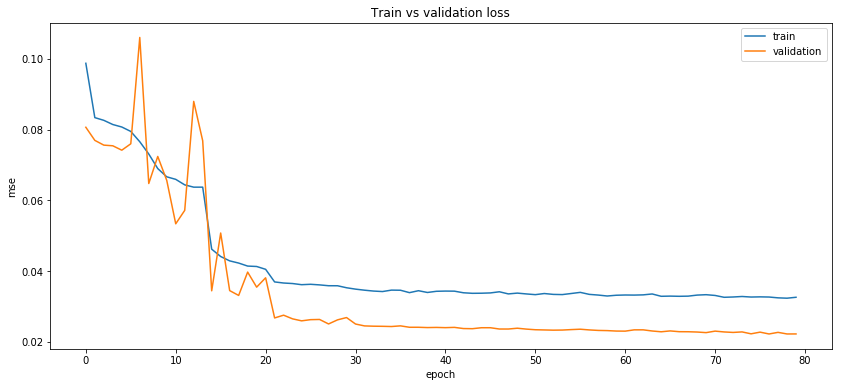

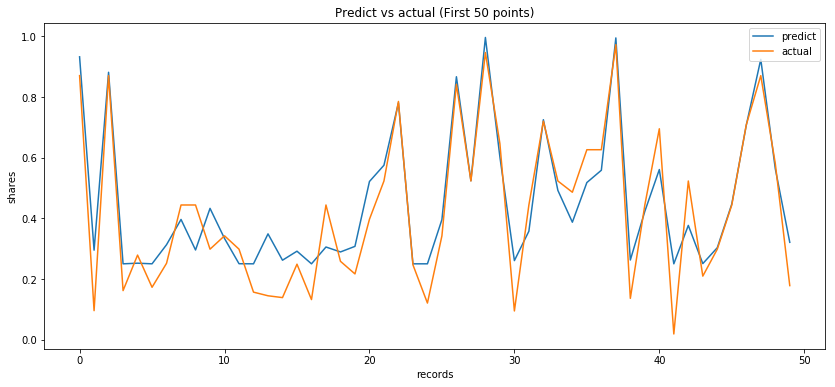

In [16]:
# showing results
scores = model.evaluate(x_test, y_test)

# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
y_pred = model.predict(x_test)

root_mse = math.sqrt(scores[1])
var_score = explained_variance_score(y_pred, y_test)
mean_abs_error = mean_absolute_error(y_pred, y_test)
mean_sqare_log_error = mean_squared_log_error(y_pred, y_test)
median_abs_error = median_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

print('actual max {0}'.format(np.max(y_test)))
print('actual min {0}'.format(np.min(y_test)))
print('actual median {0}'.format(np.median(y_test)))
print('predict max {0}'.format(np.max(y_pred)))
print('predict min {0}'.format(np.min(y_pred)))
print('predict median {0}'.format(np.median(y_pred)))
print()
print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
print('root_mse: {0}'.format(round(root_mse, 6)))
print('explained_variance_score: {0}'.format(round(var_score, 6)))
print('mean_absolute_error: {0}'.format(round(mean_abs_error, 6)))
print('mean_squared_log_error: {0}'.format(round(mean_sqare_log_error, 6)))
print('median_absolute_error: {0}'.format(round(median_abs_error, 6)))
print('r2_score: {0}'.format(round(r2, 6)))

# plt.figure(figsize=(14,6))
# plt.hist(y_pred, 100)
# plt.hist(y_test, 100)
# plt.show()

plt.figure(figsize=(14,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs validation loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# plt.figure(figsize=(14,6))
# plt.xlabel("Record count")
# plt.ylabel("Value")
# plt.title("Predict vs actual (Test set)")
# x = list(range(len(y_pred)))
# # plt.ylim(0, 1)
# plt.scatter(x, [pt[0] for pt in y_test], label='actual', alpha=0.8)
# plt.scatter(x, [pt[0] for pt in y_pred], label='prediction', alpha=0.8)
# plt.legend(loc='upper right')
# plt.show()

plt.figure(figsize=(14,6))
plt.title('Predict vs actual (First 50 points)')
plt.plot(y_pred[:50])
plt.plot(y_test[:50])
plt.ylabel('shares')
plt.xlabel('records')
plt.legend(['predict', 'actual'], loc='upper right', borderaxespad=0.5)
plt.show()

In [17]:
# kfold on dataset and training
dataset = []
labels = []
dataset, labels = load_dataset(is_normalize=True)
print('Dataset shape: {0}, Labels: {1}'.format(dataset.shape, labels.shape))

kfold_result = []

kf = KFold(n_splits=5, shuffle=True, random_state=100)
for train_index, test_index in kf.split(dataset):
    x_train, x_test = dataset[train_index], dataset[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
#     print("x_train: {0}, y_train: {1}".format(x_train.shape, y_train.shape))
#     print("x_test: {0}, y_test: {1}".format(x_test.shape, y_test.shape))
    
    # build model
    model = Sequential()
    model.add(Dense(512, input_dim=39, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_kernal)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(l2_kernal)))

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(lr=0.001),
                  metrics=['mse'])
    
    # train model
    early_stop = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=10,
                               mode='min',
                               verbose=1)

    checkpoint = ModelCheckpoint(saved_weights_name,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 period=1)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,
                                  patience=2,
                                  min_lr=0.00001,
                                  verbose=1)

    history = model.fit(x_train, y_train,
                          epochs=50,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stop, reduce_lr],
                          verbose=1)
    
    # evaluating model
    scores = model.evaluate(x_test, y_test)
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    y_pred = model.predict(x_test)    
    r2 = r2_score(y_pred, y_test)
    root_mse = math.sqrt(scores[1])    
    print('r2_score: {0}'.format(round(r2, 6)))
    print('rmse: {0}'.format(round(root_mse, 6)))
    kfold_result.append([scores[0], scores[1], r2, root_mse])

Original dataset shape: (39644, 60), Labels: (39644, 1)
Data is normalize
Outlier removed: 0
Dataset shape: (39644, 39), Labels: (39644, 1)
Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 4s 119us/step - loss: 0.0971 - mean_squared_error: 0.0824 - val_loss: 0.0852 - val_mean_squared_error: 0.0822
Epoch 2/50
31715/31715 [==============================] - 4s 110us/step - loss: 0.0825 - mean_squared_error: 0.0798 - val_loss: 0.0799 - val_mean_squared_error: 0.0770
Epoch 3/50
31715/31715 [==============================] - 3s 106us/step - loss: 0.0814 - mean_squared_error: 0.0785 - val_loss: 0.0782 - val_mean_squared_error: 0.0753
Epoch 4/50
31715/31715 [==============================] - 3s 110us/step - loss: 0.0807 - mean_squared_error: 0.0777 - val_loss: 0.0791 - val_mean_squared_error: 0.0760
Epoch 5/50
31715/31715 [==============================] - 4s 114us/step - loss: 0.0799 - mean_squared_error: 0.0765 - val_loss: 0.0772 - va

31715/31715 [==============================] - 3s 104us/step - loss: 0.0314 - mean_squared_error: 0.0201 - val_loss: 0.0230 - val_mean_squared_error: 0.0117
Epoch 48/50
31715/31715 [==============================] - 3s 103us/step - loss: 0.0313 - mean_squared_error: 0.0200 - val_loss: 0.0218 - val_mean_squared_error: 0.0105
Epoch 49/50
31715/31715 [==============================] - 3s 103us/step - loss: 0.0311 - mean_squared_error: 0.0198 - val_loss: 0.0220 - val_mean_squared_error: 0.0108
Epoch 50/50
7929/7929 [==============================] - 0s 31us/step
loss: 0.021303
mean_squared_error: 0.010027
r2_score: 0.835718
rmse: 0.100133
Train on 31715 samples, validate on 7929 samples
Epoch 1/50
31715/31715 [==============================] - 4s 118us/step - loss: 0.0979 - mean_squared_error: 0.0824 - val_loss: 0.0852 - val_mean_squared_error: 0.0818
Epoch 2/50
31715/31715 [==============================] - 3s 108us/step - loss: 0.0824 - mean_squared_error: 0.0796 - val_loss: 0.0796 - val

31715/31715 [==============================] - 4s 111us/step - loss: 0.0333 - mean_squared_error: 0.0221 - val_loss: 0.0221 - val_mean_squared_error: 0.0108
Epoch 44/50
31715/31715 [==============================] - 4s 111us/step - loss: 0.0329 - mean_squared_error: 0.0217 - val_loss: 0.0221 - val_mean_squared_error: 0.0108
Epoch 45/50
31715/31715 [==============================] - 3s 109us/step - loss: 0.0327 - mean_squared_error: 0.0215 - val_loss: 0.0222 - val_mean_squared_error: 0.0109
Epoch 46/50
31715/31715 [==============================] - 4s 112us/step - loss: 0.0332 - mean_squared_error: 0.0220 - val_loss: 0.0220 - val_mean_squared_error: 0.0107
Epoch 47/50
31715/31715 [==============================] - 3s 110us/step - loss: 0.0326 - mean_squared_error: 0.0214 - val_loss: 0.0219 - val_mean_squared_error: 0.0107
Epoch 48/50
31715/31715 [==============================] - 4s 115us/step - loss: 0.0324 - mean_squared_error: 0.0212 - val_loss: 0.0219 - val_mean_squared_error: 0.010

31715/31715 [==============================] - 3s 100us/step - loss: 0.0293 - mean_squared_error: 0.0182 - val_loss: 0.0210 - val_mean_squared_error: 0.0098
Epoch 40/50
31715/31715 [==============================] - 3s 103us/step - loss: 0.0293 - mean_squared_error: 0.0181 - val_loss: 0.0203 - val_mean_squared_error: 0.0092
Epoch 41/50
31715/31715 [==============================] - 3s 101us/step - loss: 0.0290 - mean_squared_error: 0.0179 - val_loss: 0.0231 - val_mean_squared_error: 0.0118

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 42/50
31715/31715 [==============================] - 3s 101us/step - loss: 0.0285 - mean_squared_error: 0.0175 - val_loss: 0.0196 - val_mean_squared_error: 0.0085
Epoch 43/50
31715/31715 [==============================] - 3s 102us/step - loss: 0.0281 - mean_squared_error: 0.0170 - val_loss: 0.0197 - val_mean_squared_error: 0.0085
Epoch 44/50
31715/31715 [==============================] - 3s 100us/step - loss: 0.0283 - mean_squared

Epoch 35/50
31715/31715 [==============================] - 3s 105us/step - loss: 0.0349 - mean_squared_error: 0.0239 - val_loss: 0.0239 - val_mean_squared_error: 0.0129
Epoch 36/50
31715/31715 [==============================] - 3s 104us/step - loss: 0.0351 - mean_squared_error: 0.0241 - val_loss: 0.0235 - val_mean_squared_error: 0.0124
Epoch 37/50
31715/31715 [==============================] - 3s 105us/step - loss: 0.0350 - mean_squared_error: 0.0240 - val_loss: 0.0236 - val_mean_squared_error: 0.0126
Epoch 38/50
31715/31715 [==============================] - 3s 103us/step - loss: 0.0348 - mean_squared_error: 0.0238 - val_loss: 0.0237 - val_mean_squared_error: 0.0126
Epoch 39/50
31715/31715 [==============================] - 3s 106us/step - loss: 0.0349 - mean_squared_error: 0.0239 - val_loss: 0.0235 - val_mean_squared_error: 0.0125
Epoch 40/50
31715/31715 [==============================] - 3s 104us/step - loss: 0.0349 - mean_squared_error: 0.0239 - val_loss: 0.0232 - val_mean_squared_

31716/31716 [==============================] - 3s 106us/step - loss: 0.0357 - mean_squared_error: 0.0238 - val_loss: 0.0257 - val_mean_squared_error: 0.0138
Epoch 32/50
31716/31716 [==============================] - 3s 106us/step - loss: 0.0356 - mean_squared_error: 0.0237 - val_loss: 0.0256 - val_mean_squared_error: 0.0136
Epoch 33/50
31716/31716 [==============================] - 3s 104us/step - loss: 0.0357 - mean_squared_error: 0.0238 - val_loss: 0.0256 - val_mean_squared_error: 0.0137
Epoch 34/50
31716/31716 [==============================] - 3s 104us/step - loss: 0.0359 - mean_squared_error: 0.0241 - val_loss: 0.0255 - val_mean_squared_error: 0.0136
Epoch 35/50
31716/31716 [==============================] - 3s 105us/step - loss: 0.0354 - mean_squared_error: 0.0236 - val_loss: 0.0257 - val_mean_squared_error: 0.0138
Epoch 36/50
31716/31716 [==============================] - 3s 104us/step - loss: 0.0356 - mean_squared_error: 0.0238 - val_loss: 0.0254 - val_mean_squared_error: 0.013

In [18]:
avg_loss = 0
avg_mse = 0
avg_r2 = 0
avg_root_mse = 0

for idx, scores in enumerate(kfold_result):
    avg_loss += scores[0]
    avg_mse += scores[1]
    avg_r2 += scores[2]
    avg_root_mse += scores[3]
    print('kfold {0}'.format(idx+1))
    print("{0}: {1}".format(model.metrics_names[0], round(scores[0], 6)))
    print("{0}: {1}".format(model.metrics_names[1], round(scores[1], 6)))
    print('r2_score: {0}'.format(round(scores[2], 6)))
    print('rmse: {0}'.format(round(scores[3], 6)))
    print()

print('kfold loss: {0}'.format(round(avg_loss, 6)))
print('kfold mse: {0}'.format(round(avg_mse, 6)))
print('kfold r2: {0}'.format(round((avg_r2/5), 6)))
print('kfold rmse: {0}'.format(round((avg_root_mse/5), 6)))

kfold 1
loss: 0.021303
mean_squared_error: 0.010027
r2_score: 0.835718
rmse: 0.100133

kfold 2
loss: 0.021818
mean_squared_error: 0.01061
r2_score: 0.835026
rmse: 0.103006

kfold 3
loss: 0.019042
mean_squared_error: 0.007902
r2_score: 0.879895
rmse: 0.088892

kfold 4
loss: 0.022915
mean_squared_error: 0.011889
r2_score: 0.801602
rmse: 0.109037

kfold 5
loss: 0.02464
mean_squared_error: 0.012806
r2_score: 0.78928
rmse: 0.113163

kfold loss: 0.109718
kfold mse: 0.053234
kfold r2: 0.828304
kfold rmse: 0.102846
